In [2]:
#import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import cantera as ct

print(f"Runnning Cantera version: {ct.__version__}")

Runnning Cantera version: 3.0.0


In [5]:
gas = ct.Solution("Seiser.yaml")

C:\Users\bhavik\AppData\Local\Temp\ipykernel_27156\3362316807.py:1: UserWarning: NasaPoly2::validate: 
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.83428060093267
	Value computed using high-temperature polynomial: 21.76699500201913

  gas = ct.Solution("Seiser.yaml")


In [6]:
reactor_temperature = 1000  # Kelvin
reactor_pressure = 101325  # Pascals

gas.TP = reactor_temperature, reactor_pressure

# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel="nc7h16", oxidizer={"o2": 1.0, "n2": 3.76})

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
reactor_network = ct.ReactorNet([r])

# use the above list to create a DataFrame
time_history = ct.SolutionArray(gas, extra="t")


In [7]:
def ignition_delay(states, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]

In [91]:
reference_species = "oh"

# Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimated_ignition_delay_time = 0.1
t = 0

counter = 1
while t < estimated_ignition_delay_time:
    t = reactor_network.step()
    if not counter % 10:
        # We will save only every 10th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        time_history.append(r.thermo.state, t=t)
    counter += 1

# We will use the 'oh' species to compute the ignition delay
tau = ignition_delay(time_history, reference_species)

# Toc
t1 = time.time()

print(f"Computed Ignition Delay: {tau:.3e} seconds. Took {t1-t0:3.2f}s to compute")

Computed Ignition Delay: 3.248e-02 seconds. Took 2.81s to compute


(0.0, 0.05)

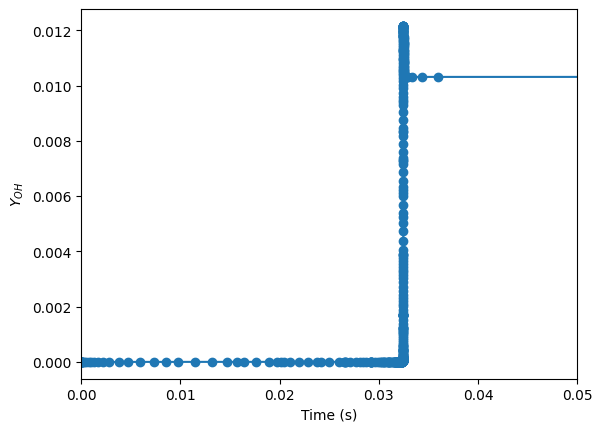

In [92]:
plt.figure()
plt.plot(time_history.t, time_history(reference_species).Y, "-o")
plt.xlabel("Time (s)")
plt.ylabel("$Y_{OH}$")

plt.xlim([0, 0.05])

In [93]:
T = np.hstack((np.arange(1800, 900, -100), np.arange(975, 475, -25)))

estimated_ignition_delay_times = np.ones_like(T, dtype=float)

# Make time adjustments for the highest and lowest temperatures. This we do empirically
estimated_ignition_delay_times[:6] = 6 * [0.1]
estimated_ignition_delay_times[-4:-2] = 10
estimated_ignition_delay_times[-2:] = 100

# Now create a SolutionArray out of these
ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra={"tau": estimated_ignition_delay_times})
ignition_delays.set_equivalence_ratio(1.0, fuel="nc7h16", oxidizer={"o2": 1.0, "n2": 3.76})
ignition_delays.TP = T, reactor_pressure

for i, state in enumerate(ignition_delays):
    # Setup the gas and reactor
    gas.TPX = state.TPX
    r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
    reactor_network = ct.ReactorNet([r])

    reference_species_history = []
    time_history = []

    t0 = time.time()

    t = 0
    while t < estimated_ignition_delay_times[i]:
        t = reactor_network.step()
        time_history.append(t)
        reference_species_history.append(gas[reference_species].X[0])

    i_ign = np.array(reference_species_history).argmax()
    tau = time_history[i_ign]
    t1 = time.time()

    ignition_delays = np.zeros(10, dtype=float)
    ignition_delays[i] = tau
    print(f"Computed Ignition Delay: {tau:.3e} seconds for T={state.T}K. Took {t1 - t0:3.2f}s to compute")


Computed Ignition Delay: 2.984e-05 seconds for T=3048.1372634219747K. Took 2.55s to compute
Computed Ignition Delay: 3.090e-05 seconds for T=3023.4797173450493K. Took 2.67s to compute
Computed Ignition Delay: 4.076e-05 seconds for T=2998.377918738475K. Took 3.07s to compute
Computed Ignition Delay: 7.168e-05 seconds for T=2972.8347979120367K. Took 3.43s to compute
Computed Ignition Delay: 1.646e-04 seconds for T=2946.8586860764713K. Took 2.68s to compute
Computed Ignition Delay: 4.749e-04 seconds for T=2920.470343277055K. Took 3.49s to compute
Computed Ignition Delay: 1.632e-03 seconds for T=2893.7088662427327K. Took 3.23s to compute
Computed Ignition Delay: 6.443e-03 seconds for T=2866.6250019783465K. Took 3.24s to compute
Computed Ignition Delay: 3.248e-02 seconds for T=2839.2914938791764K. Took 2.95s to compute
Computed Ignition Delay: 5.040e-02 seconds for T=2832.4310152026005K. Took 2.56s to compute


IndexError: index 10 is out of bounds for axis 0 with size 10